In [42]:
import numpy as np
np.random.seed(234)

from scipy.optimize import minimize, NonlinearConstraint
import matplotlib.pyplot as plt

In [43]:
# численное интергрирование методом трапеций
def integrate(function_values, points):
    h = points[1] - points[0]
    return np.sum(function_values) * h  - 0.5 * h * (function_values[0] + function_values[-1])

In [44]:
# Класс, реализующий решение задачи Чаплыгина
class ChaplyginProblemSolver:
    def __init__(self, v, w, T, x0, y0, use_cache=True):
        self.v = v
        self.w = w
        self.T = T
        self.x0 = x0
        self.y0 = y0
        self.use_cache = use_cache

        if use_cache:
            self.__de_solution_cache = dict()

            self.cached_calls = 0
            self.euler_method_calls = 0

    # правая часть дифференциального уравнения производной x по времени
    def x_right_part(self, u, i):
        return self.v * np.cos(u[i]) - self.w

    # правая часть дифференциального уравнения производной y по времени
    def y_right_part(self, u, i):
        return self.v * np.sin(u[i])

    # решение задачи Коши методом Эйлера
    def euler_method(self, u, t):
        x = np.zeros(t.shape)
        y = np.zeros(t.shape)

        n_nodes = t.shape[0]

        x[0] = self.x0
        y[0] = self.y0

        for i in range(1, n_nodes):
            x[i] = x[i-1] + (t[i] - t[i-1]) * self.x_right_part(u, i)
            y[i] = y[i-1] + (t[i] - t[i-1]) * self.y_right_part(u, i)

        return x, y

    # решение задачи Коши c кешированием результата, чтобы не решать уравнение несколько раз при проверке на ограничения
    def solve_ivp(self, u, t):
        if self.use_cache:
            key = hash(u.data.tobytes())
            if key in self.__de_solution_cache:
                self.cached_calls += 1
                return self.__de_solution_cache[key]

            result = self.euler_method(u, t)
            self.__de_solution_cache[key] = result
            self.euler_method_calls += 1
            return result
        else:
            return self.euler_method(u, t)

    # минимизируемый функционал
    def minimization_func(self, u):
        t = np.linspace(0, T, n_nodes)
        x, y = self.solve_ivp(u, t)

        function_to_integrate = x * v * np.sin(u) - y * (v * np.cos(u) - w)

        return integrate(function_to_integrate, t)

    # решение задачи Коши c кешированием результата, чтобы не решать уравнение несколько раз при проверке на ограничения
    def solve(self, n_points):
        functional = lambda u: self.minimization_func(u)

        t = np.linspace(0, T, n_points)

        def constrain_xb(u):
            x, _ = self.solve_ivp(u, t)
            return x[-1]

        def constrain_yb(u):
            _, y = self.solve_ivp(u, t)
            return y[-1]

        constrains = [NonlinearConstraint(constrain_xb, x0, x0),
                NonlinearConstraint(constrain_yb, y0, y0)]

        u0 = np.random.random(n_nodes)

        sol = minimize(functional, u0, method='trust-constr', constraints=constrains, options={'verbose': 3, 'maxiter': 200})

        x, y = self.solve_ivp(sol.x, t)

        if self.use_cache:
            print(f'cached calls: {self.cached_calls}, euler method calls: {self.euler_method_calls}, total solve calls: {self.cached_calls + self.euler_method_calls}')

        return sol.x, x, y


In [45]:
v = 1           # скорость движения самолета (в безветренную погоду)
w = -0.5        # скорость ветра (минус нужен чтобы направить ветер слева направо)

x0 = 10         # x-координата начальной точки полета
y0 = 25         # y-координата начальной точки полета

T = 1000        # время полета, за которое самолет должен вернуться в начальную точку

In [46]:
%%time
n_nodes = 100   # число отсчетов по времени (а значит и по всем остальным величинам) для которых будут расчитаны искомые величины

# конфигурация решателя задачи и, собственно, решение задачи
solver = ChaplyginProblemSolver(v, w, T, x0, y0, use_cache=True)
u_sol, x_sol, y_sol = solver.solve(n_points=n_nodes)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------|
|   1   |  101  |   0   | -2.7930e+04 | 1.00e+00 | 1.39e+04 | 1.31e+03 | 1.00e+00 |   0   |
|   2   |  202  |   1   | -7.0273e+04 | 7.00e+00 | 1.48e+04 | 1.27e+03 | 1.00e+00 |   2   |
|   3   |  303  |   2   | -2.4075e+05 | 4.90e+01 | 1.03e+04 | 9.47e+02 | 1.00e+00 |   2   |
|   4   |  404  |   5   | +5.0317e+03 | 1.07e+02 | 1.65e+03 | 7.59e+01 | 9.69e+02 |   4   |
|   5   |  505  |  10   | -7.4505e+03 | 1.07e+02 | 1.70e+03 | 1.52e+01 | 9.69e+02 |   4   |
|   6   |  606  |  16   | -1.1428e+04 | 1.07e+02 | 1.53e+03 | 3.45e+00 | 9.69e+02 |   4   |
|   7   |  707  |  22   | -1.6800e+04 | 1.07e+02 | 1.53e+03 | 1.09e+00 | 9.69e+02 |   4   |
|   8   |  808  |  29   | -2.3479e+04 | 1.07e+02 | 1.82e+03 | 6.75e-01 | 9.69e+02 |   4   |
|   9   |  909  |  36   | -3.2808e+04 | 1.07e+02 | 2.09e+03 | 3.24e+00 | 9.69e+0

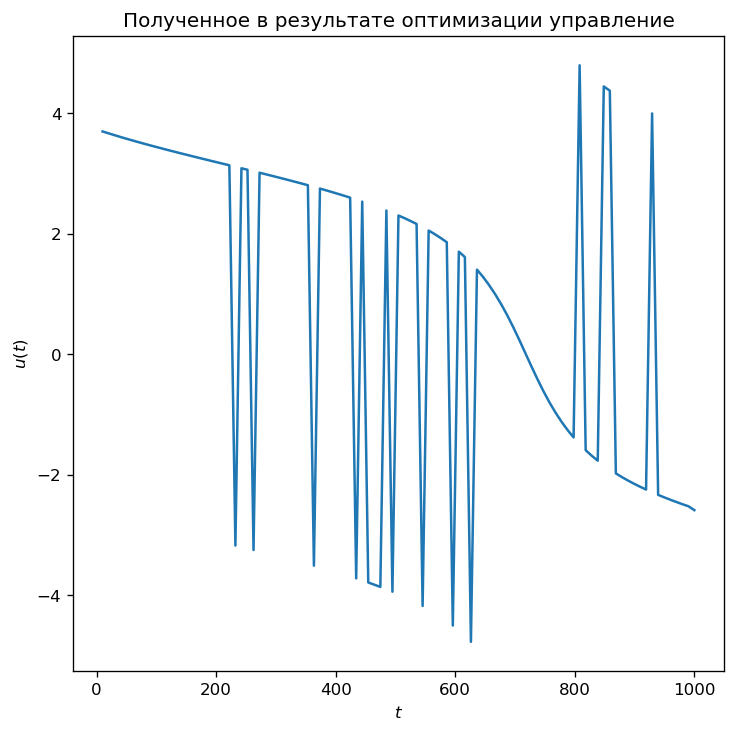

In [47]:
t = np.linspace(0, T, n_nodes)

plt.figure(figsize=(7, 7), dpi=120)
plt.plot(t[1:], u_sol[1:])
plt.title('Полученное в результате оптимизации управление')
plt.ylabel('$u(t)$')
plt.xlabel('$t$')

plt.savefig('optimization_result.png')
plt.show()

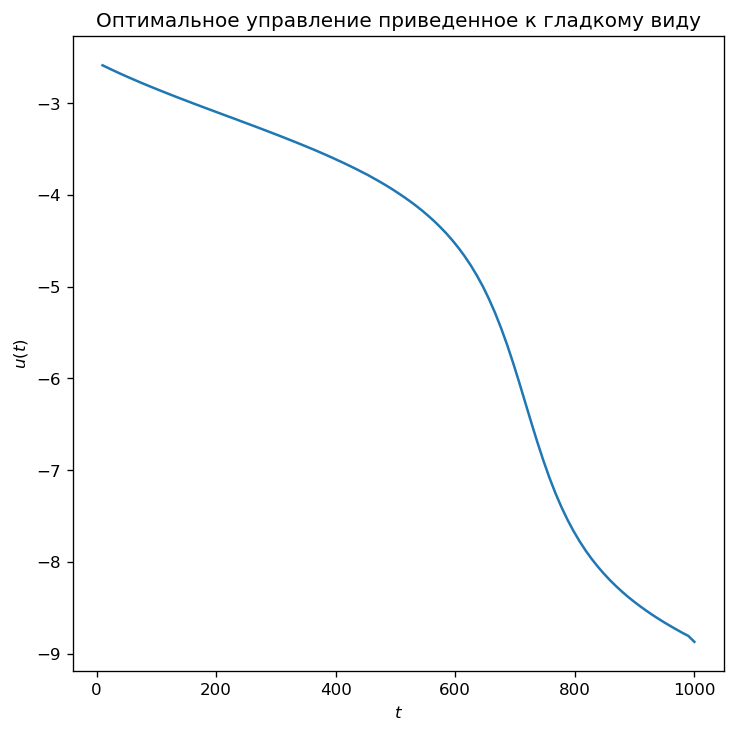

In [48]:
# функция для приведения управления к гладкому виду путем вычитания/добавления 2 * pi * k (т.к. управление -- это угол)
def reduce_period(u):
    l = [u[0]]
    for i in range(1, u.shape[0]):
        best_diff = float('inf')
        best_x = -1
        for j in range(-2, 3):
            new_x = u[i] + j * 2 * np.pi
            diff = abs(l[i-1] - new_x)
            if diff < best_diff:
                best_x = new_x
                best_diff = diff

        l.append(best_x)
    return np.array(l)

u_sol = reduce_period(u_sol)

plt.figure(figsize=(7, 7), dpi=120)
plt.plot(t[1:], u_sol[1:])
plt.title('Оптимальное управление приведенное к гладкому виду')
plt.ylabel('$u(t)$')
plt.xlabel('$t$')

plt.savefig('reduced_optimization_result.png')
plt.show()

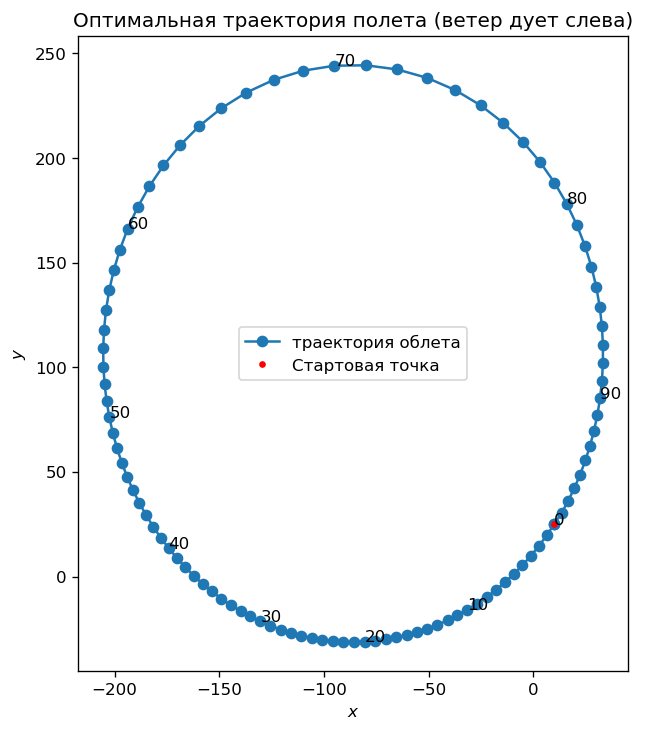

In [49]:
plt.figure(figsize=(7, 7), dpi=120)

plt.gca().set_aspect('equal', adjustable='box')

plt.plot(x_sol, y_sol, '-o', label='траектория облета')
for j, (x, y) in enumerate(zip(x_sol, y_sol)):
    if j % 10 == 0:
        plt.text(x, y, str(j))

plt.plot(x0, y0, 'r.', label='Стартовая точка')
plt.title('Оптимальная траектория полета (ветер дует слева)')
plt.ylabel('$y$')
plt.xlabel('$x$')
plt.legend()
plt.savefig('optimal_trajectory.png')
plt.show()

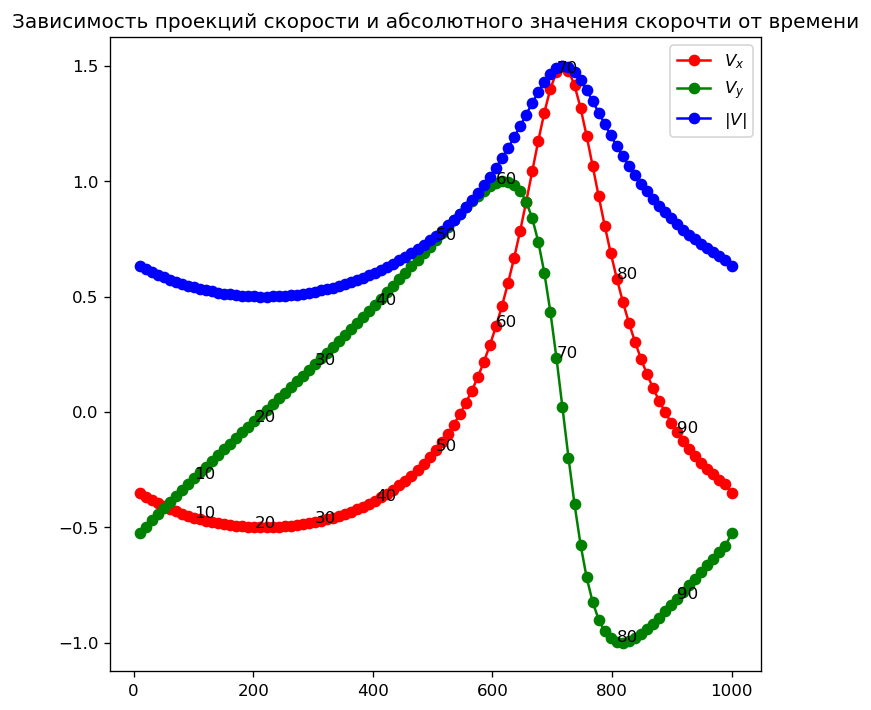

In [50]:
vx = v * np.cos(u_sol) - w
vy = v * np.sin(u_sol)
v_abs = np.sqrt(vx ** 2 + vy ** 2)

plot_start_index = 1

plt.figure(figsize=(7, 7), dpi=120)

plt.plot(t[plot_start_index:], vx[plot_start_index:], 'r-o', label='$V_{x}$')
plt.plot(t[plot_start_index:], vy[plot_start_index:], 'g-o', label='$V_{y}$')
plt.plot(t[plot_start_index:], v_abs[plot_start_index:], 'b-o', label='$|V|$')

plt.title('Зависимость проекций скорости и абсолютного значения скорочти от времени')

for j in range(plot_start_index, vx.shape[0]):
    if j % 10 == 0:
        plt.text(t[j], vx[j], str(j))
        plt.text(t[j], vy[j], str(j))
        
plt.legend()
plt.savefig('velocities.png')

plt.show()

In [51]:
n_nodes = 50

sols = []

different_solutions = 5
for i in range(different_solutions):
    solver = ChaplyginProblemSolver(v, w, T, x0, y0, use_cache=True)
    sols.append(solver.solve(n_points=n_nodes))

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------|
|   1   |  51   |   0   | -4.1084e+04 | 1.00e+00 | 2.81e+04 | 1.31e+03 | 1.00e+00 |   0   |
|   2   |  102  |   1   | -1.0350e+05 | 7.00e+00 | 2.71e+04 | 1.25e+03 | 1.00e+00 |   2   |
|   3   |  153  |   2   | -2.2859e+05 | 4.90e+01 | 1.48e+04 | 6.81e+02 | 1.00e+00 |   2   |
|   4   |  204  |   5   | -2.2893e+04 | 5.08e+01 | 3.73e+03 | 8.21e+01 | 9.85e+02 |   4   |
|   5   |  255  |   9   | -1.2375e+04 | 5.08e+01 | 2.43e+03 | 2.63e+00 | 9.85e+02 |   4   |
|   6   |  306  |  14   | -1.5953e+04 | 5.08e+01 | 2.41e+03 | 1.13e+00 | 9.85e+02 |   4   |
|   7   |  357  |  19   | -2.0515e+04 | 5.08e+01 | 2.80e+03 | 5.71e-01 | 9.85e+02 |   4   |
|   8   |  408  |  25   | -2.6740e+04 | 5.08e+01 | 3.67e+03 | 9.30e-01 | 9.85e+02 |   4   |
|   9   |  459  |  31   | -3.4796e+04 | 5.08e+01 | 4.60e+03 | 1.33e+00 | 9.85e+0

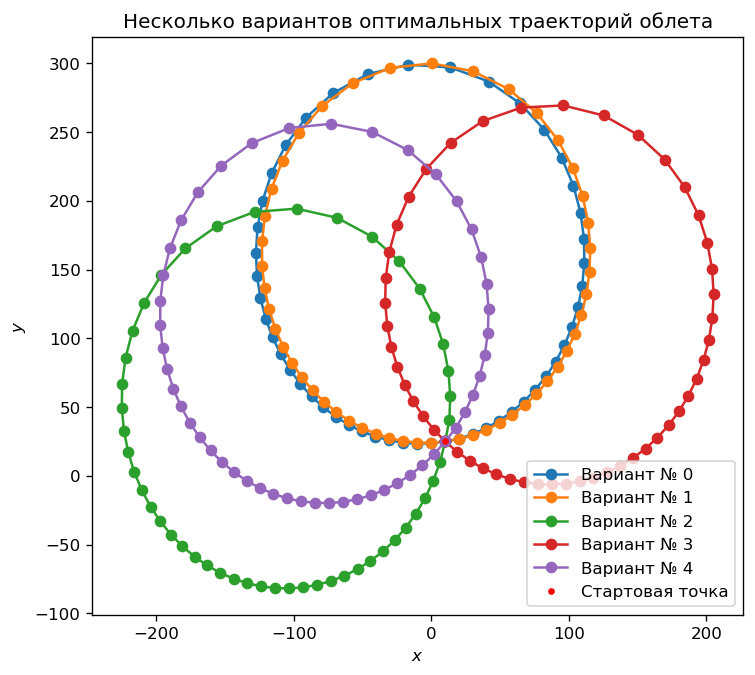

In [52]:
plt.figure(figsize=(7, 7), dpi=120)

plt.gca().set_aspect('equal', adjustable='box')

for i, sol in enumerate(sols):
    _, x_sol, y_sol = sol
    plt.plot(x_sol, y_sol, '-o', label=f'Вариант № {i}')

plt.plot(x0, y0, 'r.', label='Стартовая точка')
plt.title('Несколько вариантов оптимальных траекторий облета')
plt.ylabel('$y$')
plt.xlabel('$x$')
plt.legend()
plt.savefig('multiple_trajectories.png')

plt.show()

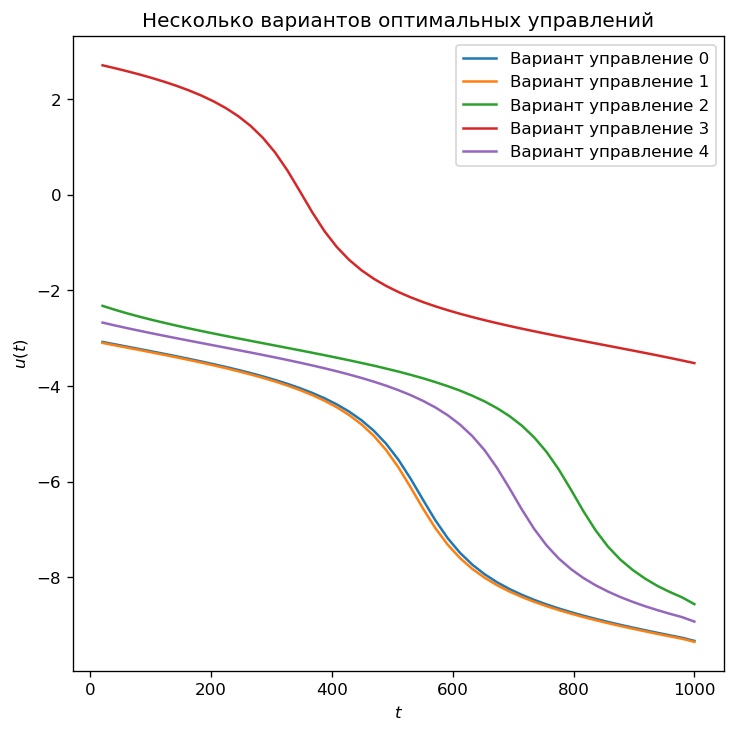

In [53]:
plt.figure(figsize=(7, 7), dpi=120)

t = np.linspace(0, T, n_nodes)

for i, sol in enumerate(sols):
    u_sol = reduce_period(sol[0])
    plt.plot(t[1:], u_sol[1:], label=f'Вариант управление {i}')

plt.title('Несколько вариантов оптимальных управлений')
plt.ylabel('$u(t)$')
plt.xlabel('$t$')
plt.legend()

plt.savefig('multiple_controls.png')
plt.show()